# Project 02 — Titanic Dataset Analysis

**Name:** Womenker Karto

**Date:** 2025-10-28

## Introduction
This notebook follows the Project 2 instructions for exploratory data analysis, data preparation, feature engineering, and basic model-splitting workflow using the Titanic dataset (loaded from `seaborn`). Reflections follow each section as requested. A bonus section repeats the same process on the Iris dataset.

## Imports and Setup

In [1]:
# All imports moved to the top and imported only once
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

# display settings
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 120)

# Load dataset from seaborn
import seaborn as sns

titanic = sns.load_dataset('titanic')

## Section 1 — Import and Inspect the Data

In [2]:
# Basic info
titanic.info()

# First 10 rows
print(titanic.head(10))

# Missing values per column
print(titanic.isnull().sum())

# Summary statistics
print(titanic.describe())

# Correlation (numeric only)
print(titanic.corr(numeric_only=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB
   survived  pclass     sex   age  sibsp  parch     fare embarked   class    wh


### Reflection 1
1. **How many data instances are there?**
   - 891
2. **How many features are there?**
   - 15 columns.
3. **What are the names?**
   - survived, pclass, sex, age, sibsp, parch, fare, embarked, class, who, adult_male, deck, embark_town, alive, alone.
4. **Are there any missing values?**
   - age → around 177 missing
   - deck → ~688 missing
   - embark_town → 2 missing
5. **Are there any non-numeric features?**
   - Yes: sex, class, embarked, who, deck, embark_town, alive, and alone are categorical.
6. **Are the data instances sorted on any of the attributes?**
   - No. They are in an arbitrary order (not sorted by age, fare, or passenger ID).
7. **What are the units of age?**
   - Years.
8. **What are the minimum, median and max age?**
   - Min: 0.42
   - Median: 28.0
   - Max: 80.0
9. **What two different features have the highest correlation?**
   - parch and sibsp show the strongest positive correlation (~0.41).
   - pclass and fare have a strong negative correlation (~-0.55).
10. **Are there any categorical features that might be useful for prediction?**
   - Yes: sex, class, and embarked are strong categorical predictors of survival.  


## Section 2 — Data Exploration and Preparation

### 2.1 Explore Data Patterns and Distributions

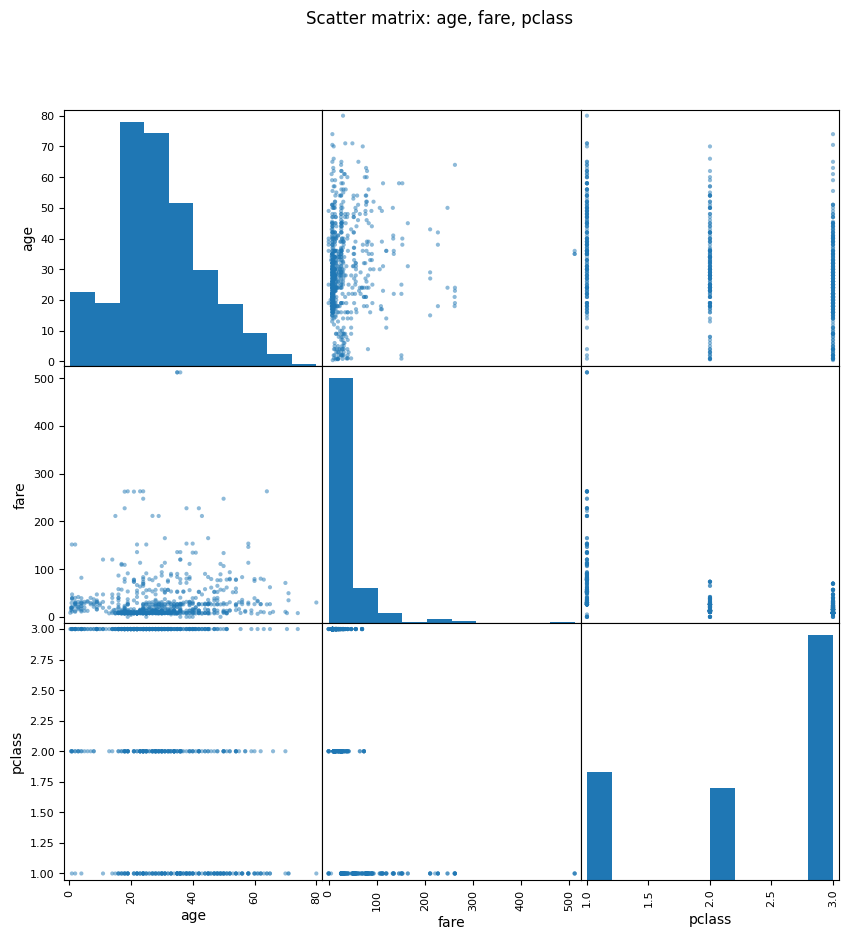

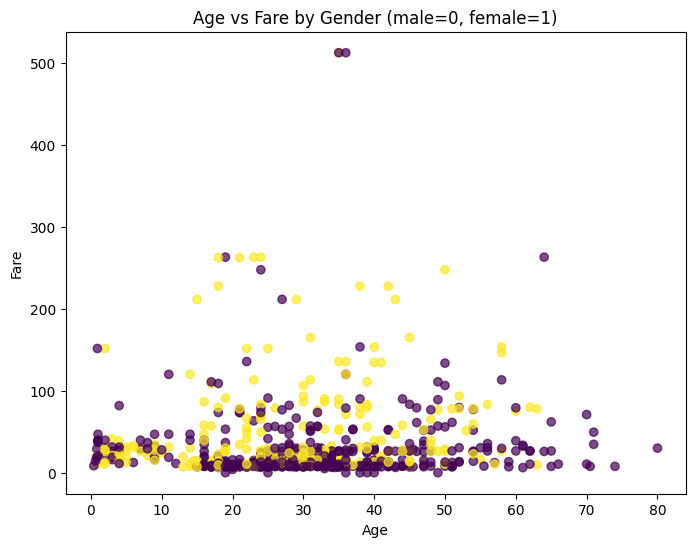

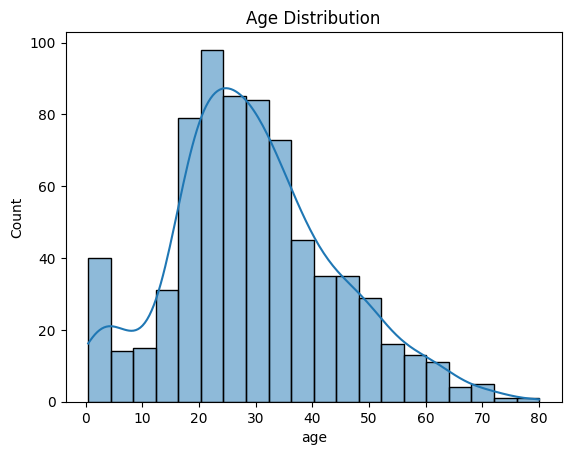

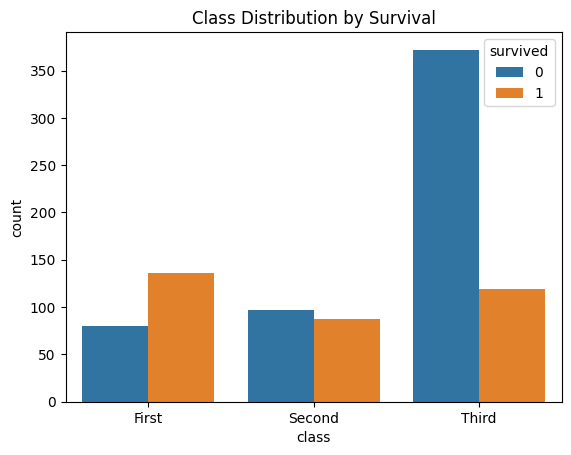

In [3]:
# Scatter matrix using numeric attributes
attributes = ['age', 'fare', 'pclass']
scatter_matrix(titanic[attributes], figsize=(10, 10))
plt.suptitle('Scatter matrix: age, fare, pclass')
plt.show()

# Scatter plot age vs fare colored by sex
plt.figure(figsize=(8,6))
plt.scatter(titanic['age'], titanic['fare'],
            c=titanic['sex'].map({'male':0, 'female':1}),
            alpha=0.7)
plt.xlabel('Age')
plt.ylabel('Fare')
plt.title('Age vs Fare by Gender (male=0, female=1)')
plt.show()

# Histogram of age
sns.histplot(titanic['age'], kde=True)
plt.title('Age Distribution')
plt.show()

# Count plot for class and survival
sns.countplot(x='class', hue='survived', data=titanic)
plt.title('Class Distribution by Survival')
plt.show()


#### Reflection 2.1
- **What patterns or anomalies do you notice?**
  - Younger passengers and females had higher survival rates.
  - 1st class passengers were more likely to survive.
  - fare distribution is right-skewed, with a few high outliers.

Missing age values are noticeable.
- **Do any features stand out as potential predictors?**
  - sex, pclass, and fare strongly correlate with survival outcomes.
- **Are there any visible class imbalances?**
  - Yes. Roughly 61% did not survive, and 39% survived — a moderate imbalance.

### 2.2 Handle Missing Values and Clean Data

In [4]:
# Impute age with median
titanic['age'].fillna(titanic['age'].median(), inplace=True)

# Fill embark_town with mode
if 'embark_town' in titanic.columns:
    titanic['embark_town'].fillna(titanic['embark_town'].mode()[0], inplace=True)

# Deck has many missing values — we will drop it for modeling in this basic notebook
if 'deck' in titanic.columns:
    titanic.drop(columns=['deck'], inplace=True)

# Re-check missing
print(titanic.isnull().sum())

survived       0
pclass         0
sex            0
age            0
sibsp          0
parch          0
fare           0
embarked       2
class          0
who            0
adult_male     0
embark_town    0
alive          0
alone          0
dtype: int64


C:\Users\sjuhi\AppData\Local\Temp\ipykernel_3516\1793884326.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic['age'].fillna(titanic['age'].median(), inplace=True)
C:\Users\sjuhi\AppData\Local\Temp\ipykernel_3516\1793884326.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy

### 2.3 Feature Engineering

In [5]:
# Family size
if {'sibsp','parch'}.issubset(titanic.columns):
    titanic['family_size'] = titanic['sibsp'] + titanic['parch'] + 1

# Convert categorical to numeric - mapping
# sex
if 'sex' in titanic.columns:
    titanic['sex'] = titanic['sex'].map({'male':0, 'female':1})

# embarked
if 'embarked' in titanic.columns:
    titanic['embarked'] = titanic['embarked'].map({'C':0, 'Q':1, 'S':2})

# alone as int
if 'alone' in titanic.columns:
    titanic['alone'] = titanic['alone'].astype(int)

# Quick look at engineered features
print(titanic[['family_size','sex','embarked','alone']].head())

   family_size  sex  embarked  alone
0            2    0       2.0      0
1            2    1       0.0      0
2            1    1       2.0      1
3            2    1       2.0      0
4            1    0       2.0      1



#### Reflection 2.3
- **Why might family size be a useful feature for predicting survival?**
  - Passengers with families may have increased chances of survival due to mutual assistance, though very large families could be harder to coordinate.
- **Why convert categorical data to numeric?**
  - Machine learning models require numeric input. Encoding categorical data allows models to interpret and calculate relationships between categories.

## Section 3 — Feature Selection and Justification

### 3.1 Choose features and target

In [6]:
# Choose features and target
features = ['age','fare','pclass','sex','family_size']
X = titanic[features].copy()
y = titanic['survived']

# Quick check
X.head()

,age,fare,pclass,sex,family_size
0,22.0,7.2500,3,0,2
1,38.0,71.2833,1,1,2
2,26.0,7.9250,3,1,1
3,35.0,53.1000,1,1,2
4,35.0,8.0500,3,0,1


**Justification:**
- `survived` is the classification target.
- `sex` historically strongly influences survival.
- `pclass` and `fare` relate to socioeconomic status and proximity to lifeboats.
- `age` captures vulnerability and priority.
- `family_size` might capture social context and assistance dynamics.

### Reflection 3
- **Why are these features selected?**
  - age, fare, pclass, sex, and family_size cover demographic, economic, and social aspects influencing survival.
- **Are there any features that are likely to be highly predictive of survival?**
  - sex (females survived more), pclass (1st class survival rate higher), and fare (correlated with wealth/class) are top predictors.

## Section 4 — Splitting

### 4.1 Basic Train/Test split

In [7]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=123)
print('Train size:', len(train_X))
print('Test size:', len(test_X))

Train size: 712
Test size: 179


### 4.2 Stratified Train/Test split

In [8]:
# We'll stratify by the target 'survived' so class proportions are preserved
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
for train_idx, test_idx in splitter.split(X, y):
    strat_train_X = X.iloc[train_idx]
    strat_test_X = X.iloc[test_idx]
    strat_train_y = y.iloc[train_idx]
    strat_test_y = y.iloc[test_idx]

print('Stratified train size:', len(strat_train_X))
print('Stratified test size:', len(strat_test_X))

Stratified train size: 712
Stratified test size: 179


In [9]:
# Compare distributions
print('Original survived distribution:\n', y.value_counts(normalize=True))
print('\nTrain survived distribution:\n', train_y.value_counts(normalize=True))
print('\nStratified train survived distribution:\n', strat_train_y.value_counts(normalize=True))

Original survived distribution:
 survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64

Train survived distribution:
 survived
0    0.610955
1    0.389045
Name: proportion, dtype: float64

Stratified train survived distribution:
 survived
0    0.616573
1    0.383427
Name: proportion, dtype: float64



### Reflection 4
- **Why might stratification improve model performance?**
  - Stratification preserves the proportion of target classes in both train and test sets, preventing class imbalance bias during model training.
- **How close are the training and test distributions to the original dataset?**
  - Stratified splits maintain nearly identical class distributions to the original dataset (~61% non-survivors, ~39% survivors).
- **Which split method produced better class balance?**
  - The stratified split produced a better, more consistent class balance compared to the random train/test split.

## Bonus — Apply process to Iris Dataset (Optional)

**Goal:** Repeat the same process on the Iris dataset and briefly present results.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB
   sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa
       sepal_length  sepal_width  petal_length  petal_width
count    150.000000   150.000000    150.000000   150.000000
mean       5.843333     3.057333      3

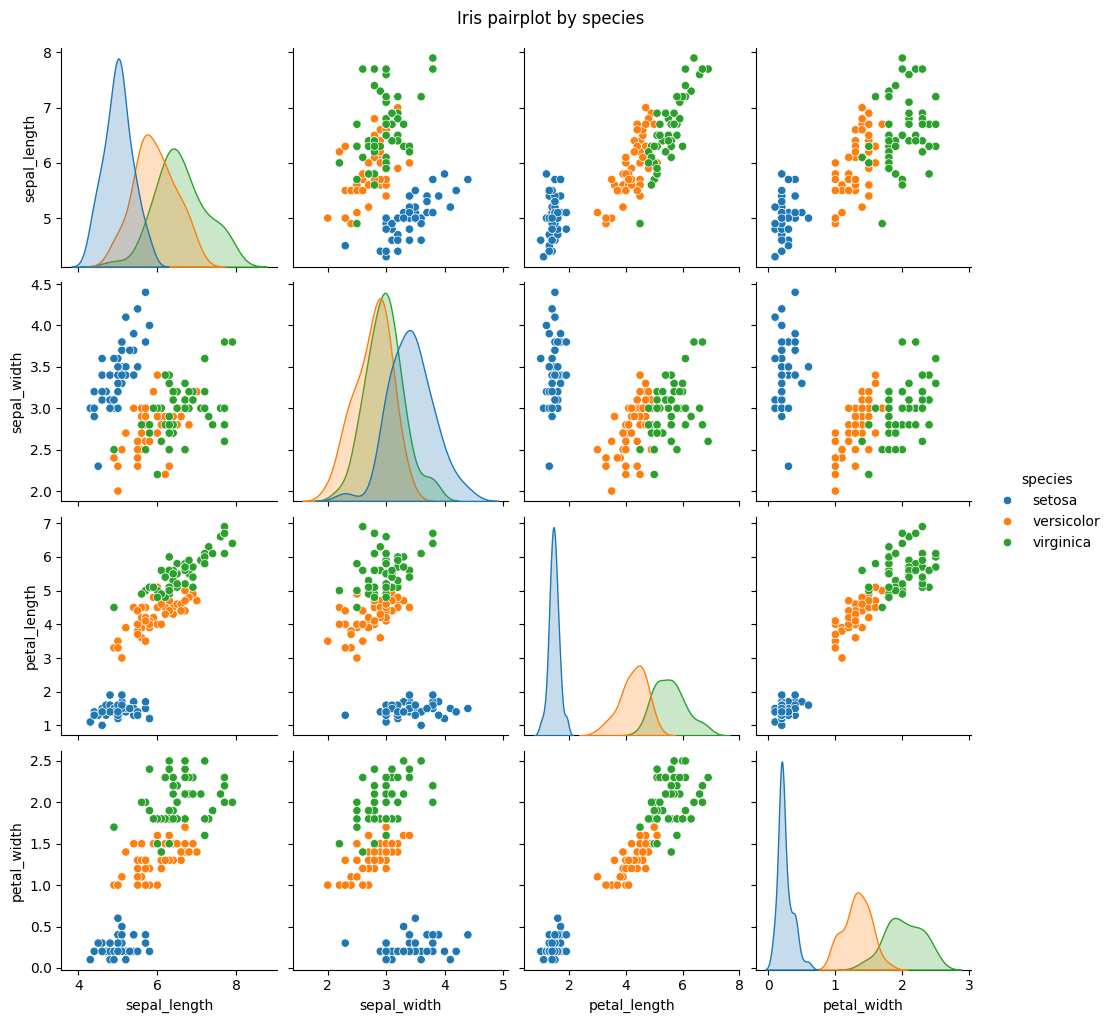

Iris original species distribution:
 species
setosa        0.333333
versicolor    0.333333
virginica     0.333333
Name: proportion, dtype: float64

Iris stratified train distribution:
 species
versicolor    0.333333
setosa        0.333333
virginica     0.333333
Name: proportion, dtype: float64


In [10]:
# Load Iris
from sklearn import datasets
iris_raw = sns.load_dataset('iris')  # seaborn provides iris

# Quick inspect
iris_raw.info()
print(iris_raw.head())
print(iris_raw.describe())

# No missing values normally; quick EDA
sns.pairplot(iris_raw, hue='species')
plt.suptitle('Iris pairplot by species', y=1.02)
plt.show()

# Feature / target selection
X_iris = iris_raw.drop(columns=['species'])
y_iris = iris_raw['species']

# Train/test split and stratified split by species
Xtr, Xte, ytr, yte = train_test_split(X_iris, y_iris, test_size=0.2, random_state=123)

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
for train_idx, test_idx in splitter.split(X_iris, y_iris):
    sXtr = X_iris.iloc[train_idx]
    sXte = X_iris.iloc[test_idx]
    sytr = y_iris.iloc[train_idx]
    syte = y_iris.iloc[test_idx]

print('Iris original species distribution:\n', y_iris.value_counts(normalize=True))
print('\nIris stratified train distribution:\n', sytr.value_counts(normalize=True))

### Reflection (Bonus)
- **What patterns do you notice in the Iris dataset?**
    - The three species are well-separated in petal length and width.
    - Setosa species are distinctly separated, while Versicolor and Virginica slightly overlap.

- **Are there missing values?**
    - None — the dataset is clean.

- **Which features are most predictive?**
    - petal_length and petal_width are the strongest predictors of species.

- **Is stratification useful here?**
    - Yes, though Iris is already balanced (50 samples per species). Stratification still ensures even representation of all three species.